<a href="https://colab.research.google.com/github/Presdigitator/abstract-generator/blob/main/Introduction_to_Deep_Learning_in_PyTorch_(Filled).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Deep Learning in PyTorch**

*QWER Hacks $\times$ ACM AI*

Jordan Lin & Jackson Steele

## What is Deep Learning?

<img src="https://drive.google.com/uc?export=view&id=1rr32TX08s4_M6LVR0HVO8ndr5QY2Q-Q7" width="700">

### Some Key Terms

*   **Artificial Intelligence**
  - Refers to the general concept of a computer doing things that would normally require a human
*   **Machine Learning**
  - A subset of Artifical Intelligence
  - Most 'Artificial Intelligence' you see referred to today is more precisely referring to Machine Learning
  - A methodology by which a computer algorithm is able to modify itself given data (in other words, it is able to *learn*)
* **Deep Learning**
  - A subset of machine learning
  - An approach to machine learning in which a neural network is used to better be able to learn/identify patterns
* **Neural Networks**
  - A model of thousands of weights in several layers
  - Involves a lot of complicated math that we don't really need to worry about right now
  - Theoretically supposed to approximate how a human brain works

### Using Deep Learning

#### Part 1: Big Data
If you want to make a deep learning model, you need data, and a lot of it.  Your model is probably going to need thousands of different data points at a minimum if you want to have a high level of accuracy.  This is the data that your model needs in order to 'learn' - computers are a lot worse than humans at learning, so a task that could be taught to a human with just a few examples is going to need orders of magnitude more examples for your model to learn off of.  On top of having a lot of data, there's another very important consideration&mdash;

#### Part 1.5: Avoiding Bias/Unintended Patterns

Deep learning models and techniques are designed to be very good at pattern recognition.  This means your model is probably going to pick up on any patterns present in the data, intentional or not.  This means we need to avoid any bias/patterns that could confuse our model.  For example, if we were training an image recognition model to distinguish between cats and dogs, and most of our cat pictures were taken inside while most of our dog pictures were taken outside, the model would probably struggle to correctly label dogs that were indoors.  So whenever you are deciding on what data to use, you want to try your best to avoid any unwanted patterns.

#### Part 2: Understanding our Data

Now that you have your data, you need to come up with a way for the model to understand your data.  There's a lot of fascinating techniques for this, and it can vary depending on what you're trying to do - to give an example, you can't load image data using a method designed for text.  Thankfully, most of the heavy lifting for this is built into pytorch (the library we are using), so you don't need to understand all the minutiae.

#### Part 3: Making the Network

You need to actually define the parameters of the neural network you would like to make.  You have to decide how many layers the network should have, how many nodes each layer should have, both of which can drastically effect the accuracy of the model.  Thankfully, once again pytorch does most of the heavy lifting here, so we can just tell it the parameters we would like and it will make the network for us.  We also need a loss function.  Essentially, our model has no way of knowing if it's doing good or bad, so we need to tell it how to calculate how good it's doing.  This is what the loss function is for.

#### Part 4: Training

Once we have everything set up, we can begin training our model!  This is mostly just a waiting game, but we do get to decide how long the model is going to train for.  In general, we don't want the model to train for too short a period of time, because then it won't have enough time to get accurate.  But after a certain point, models tend to give diminishing returns.  There's usually a level of accuracy that once reached, is very hard to meaningfully improve upon, so training for longer won't really deliver that much in terms of performance.

#### We're done!

Now that we have a trained model, we're pretty much done!  This model can now be saved for future use, and hopefully it does a pretty good job at whatever we wanted it to.

## PyTorch Tutorial :)

In [ ]:
# numpy: the library that deals with linear algebra calculations
import numpy as np
# (py)torch: our machine learning library!
import torch
import torch.nn.functional as F
from torch import nn, optim, utils
from torchvision import datasets, transforms
# matplotlib: the library for making plots & displaying images
import matplotlib.pyplot as plt
# tqdm: the library for displaying progress bars
from tqdm.notebook import tqdm

In [ ]:
# use GPU is GPU (CUDA) is available, use CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Data

We are using CIFAR-10, which comprises of $50000$ training images and $10000$ testing images with dimensions $32 \times 32 \times 3$ (square image $32$ in width, $3$ for the RGB channels).

You may see that we first download the images to store in a `Datasets` object, which stores the unprocessed images (and handles the downloading, etc.). Then, we turn the `Datasets` object into a `DataLoader` object, which gives us an iterator that allows us to iterate through the entire dataset one `batch_size` of images at a time and is very helpful for training.

In [ ]:
# pre-process images
transform = transforms.Compose([transforms.ToTensor()])  # convert image to pytorch tensor
# download images and create PyTorch Dataset & DataLoader objects
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# these are the CIFAR-10 classes, 0 for plane, 1 for car, 2 for bird, etc.
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

These are the CIFAR-10 classes and what they look like.

<img src="https://pytorch.org/tutorials/_images/cifar10.png" width="700">

In [ ]:
# data augmentation to prevent overfitting
data_augmentation = nn.Sequential(transforms.RandomHorizontalFlip(),
                                  transforms.RandomCrop((32, 32), padding=(4, 4)))
data_augmentation = torch.jit.script(data_augmentation)  # scriptify to make augmentation run faster

## Network

<img src="https://drive.google.com/uc?export=view&id=1hbdLbIbee3dZYUseQdmjiSBMKXnMYaIg" width="700">

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        """Initialize the CNN network and define its layers"""
        super().__init__()

        # there are many different ways of defining a PyTorch model, nn.Sequential is just the most
        # convenient one as everything is in one callable 'thing' and executes in sequence
        self.network = nn.Sequential(
            # layer 1: b x 3 x 32 x 32 -> b x 32 x 16 x 16 (format: channel x width x height)
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # layer 2: b x 32 x 16 x 16 -> b x 64 x 8 x 8
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # layer 3: b x 64 x 8 x 8 -> b x 64 x 4 x 4
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # flatten and output fully-connected layer
            nn.Flatten(),  # b x 64 x 4 x 4 -> b x (64 * 4 * 4)
            nn.Linear(64 * 4 * 4, 10))  # b x (64 * 4 * 4) -> b x 10
        # ... however, you can do something like:
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        # self.relu1 = nn.ReLU()
        # sekf.batch_norm1 = nn.BatchNorm2d(32)
        # ...
        # and then in the forward function sequentially pass x through these class variables
    
    def forward(self, x):
        """Pass input x through the network to obtain an output"""
        output = self.network(x)
        return output

    def size(self):
        """Count the number of parameters (i.e., size of weights) in the network"""
        parameters = self.parameters()
        size = 0
        for parameter in parameters:
            size += np.prod(parameter.shape)
        return size

In [ ]:
network = CNN()
network.to(device)  # if we are using GPU, put the network weights on the GPU

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [ ]:
print(f"Network size: {network.size()}")

Network size: 68426


## Criterion and Optimizer

The **criterion**, or loss function, or objective (this thing has a lot of names) takes the network output and labels (or ground truth, i.e., what the network is *supposed* to predict) and returns a single value, called the **loss**, that essentially *measures* and *quantifies* how well our network is performing. **The lower the loss, the better our model is doing.** Hence, we want to minimize the loss.

The **optimizer** takes the gradients (gradient of the loss function w.r.t. the network parameters) and applies them to the network weights/parameters, i.e., nudging the network in the direction of the greatest descent for the loss to minimize it.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(network.parameters(), lr=0.0003, weight_decay=1e-5)

## Training

It is *bad practice* to not split the training set further into the *actual* training set and validation set, where we train on the new (slightly smaller) training set and tune our hyperparameters according to how the validation set is doing in terms of accuracy, etc.

The reason we do so is because the testing set should be **unseen data**, and if we tune our hyperparameters based on its performance, even though the network was never directly trained on it, *we* are being affected by the results of its performance and *we* are the ones who tune the network, so the network is, in a way, still being affected by it.

We are not using validation set here and just evaluating on the testing set, which is not the greatest. However, for demonstration sake this is just simpler :P

In [ ]:
@torch.no_grad()  # we don't want to compute gradients here!
def evaluate(loader, network, criterion):
    network.eval()  # put network into evaluation mode (mostly for batch normalization)
    losses = []
    accuracies = []
    for inputs, labels in loader:
        inputs = inputs.to(device)  # put inputs and labels on GPU (if it is available)
        labels = labels.to(device)
        outputs = network(inputs)  # pass inputs through network to get outputs
        loss = criterion(outputs, labels)  # evaluate outputs with criterion to get loss
        accuracy = (torch.max(outputs, dim=1)[1] == labels).to(torch.float32).mean()  # accuracy
        losses.append(loss.cpu().numpy())
        accuracies.append(accuracy.cpu().numpy())
    return np.mean(losses), np.mean(accuracies)

In [ ]:
epoch_max = 32  # you can increase this if you want (takes longer, but accuracy will be higher)
results = {"train losses": [], "train accuracies": [], "test losses": [], "test accuracies": []}

for epoch in tqdm(range(epoch_max)):
    for inputs, labels in tqdm(train_loader, leave=False):
        inputs = inputs.to(device)  # put inputs and labels on GPU (if it is available)
        labels = labels.to(device)
        inputs = data_augmentation(inputs)  # perform data augmentation on inputs
        network.train()  # put network into training mode (mostly for batch normalization)
        optimizer.zero_grad()  # zero-out gradients
        outputs = network(inputs)  # pass inputs through network to get outputs
        loss = criterion(outputs, labels)  # evaluate outputs bwith criterion to get loss
        loss.backward()  # backpropagate through loss to compute gradients (loss w.r.t. weights)
        optimizer.step()  # use gradients to perform optimization (e.g., NAdam)
    
    # after every epoch, evaluate results on the entire training & testing set (slow)
    train_loss, train_accuracy = evaluate(train_loader, network, criterion)
    test_loss, test_accuracy = evaluate(test_loader, network, criterion)
    # store results
    results["train losses"].append(train_loss)
    results["train accuracies"].append(train_accuracy)
    results["test losses"].append(test_loss)
    results["test accuracies"].append(test_accuracy)
    # print results so we can see how the network is doing
    result = f"{('[' + str(epoch + 1) + ']'):5s}   "\
                f"Train: {str(train_accuracy * 100):.6}% ({str(train_loss):.6})   "\
                f"Test: {str(test_accuracy * 100):.6}% ({str(test_loss):.6})"
    tqdm.write(result)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %245 : int = prim::profile_ivalue(%out_dtype.2)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)


[1]     Train: 47.341% (1.4471)   Test: 46.696% (1.4466)


  0%|          | 0/391 [00:00<?, ?it/s]

[2]     Train: 49.575% (1.4188)   Test: 48.922% (1.4294)


  0%|          | 0/391 [00:00<?, ?it/s]

[3]     Train: 55.977% (1.2323)   Test: 55.053% (1.2471)


  0%|          | 0/391 [00:00<?, ?it/s]

[4]     Train: 58.053% (1.2060)   Test: 57.140% (1.2183)


  0%|          | 0/391 [00:00<?, ?it/s]

[5]     Train: 59.257% (1.1566)   Test: 58.237% (1.1841)


  0%|          | 0/391 [00:00<?, ?it/s]

[6]     Train: 62.247% (1.0707)   Test: 61.273% (1.0954)


  0%|          | 0/391 [00:00<?, ?it/s]

[7]     Train: 65.736% (0.9734)   Test: 65.011% (0.9989)


  0%|          | 0/391 [00:00<?, ?it/s]

[8]     Train: 66.027% (0.9832)   Test: 64.695% (1.0054)


  0%|          | 0/391 [00:00<?, ?it/s]

[9]     Train: 64.684% (1.0097)   Test: 63.696% (1.0463)


  0%|          | 0/391 [00:00<?, ?it/s]

[10]    Train: 66.968% (0.9351)   Test: 65.911% (0.9654)


  0%|          | 0/391 [00:00<?, ?it/s]

[11]    Train: 69.427% (0.8841)   Test: 67.958% (0.9256)


  0%|          | 0/391 [00:00<?, ?it/s]

[12]    Train: 68.793% (0.8874)   Test: 67.563% (0.9202)


  0%|          | 0/391 [00:00<?, ?it/s]

[13]    Train: 70.195% (0.8556)   Test: 69.046% (0.8945)


  0%|          | 0/391 [00:00<?, ?it/s]

[14]    Train: 69.382% (0.8841)   Test: 68.008% (0.9245)


  0%|          | 0/391 [00:00<?, ?it/s]

[15]    Train: 71.097% (0.8266)   Test: 70.005% (0.8715)


  0%|          | 0/391 [00:00<?, ?it/s]

[16]    Train: 72.470% (0.7903)   Test: 70.460% (0.8370)


  0%|          | 0/391 [00:00<?, ?it/s]

[17]    Train: 70.567% (0.8440)   Test: 69.204% (0.8892)


  0%|          | 0/391 [00:00<?, ?it/s]

[18]    Train: 71.855% (0.8026)   Test: 70.698% (0.8493)


  0%|          | 0/391 [00:00<?, ?it/s]

[19]    Train: 71.554% (0.8176)   Test: 71.034% (0.8548)


  0%|          | 0/391 [00:00<?, ?it/s]

[20]    Train: 74.359% (0.7326)   Test: 73.259% (0.7817)


  0%|          | 0/391 [00:00<?, ?it/s]

[21]    Train: 73.513% (0.7558)   Test: 71.983% (0.8124)


  0%|          | 0/391 [00:00<?, ?it/s]

[22]    Train: 73.950% (0.7410)   Test: 72.161% (0.8057)


  0%|          | 0/391 [00:00<?, ?it/s]

[23]    Train: 74.150% (0.7411)   Test: 72.646% (0.7929)


  0%|          | 0/391 [00:00<?, ?it/s]

[24]    Train: 73.187% (0.7631)   Test: 72.329% (0.8109)


  0%|          | 0/391 [00:00<?, ?it/s]

[25]    Train: 74.939% (0.7213)   Test: 72.468% (0.7932)


  0%|          | 0/391 [00:00<?, ?it/s]

[26]    Train: 74.257% (0.7276)   Test: 73.002% (0.7875)


  0%|          | 0/391 [00:00<?, ?it/s]

[27]    Train: 74.260% (0.7387)   Test: 73.556% (0.7955)


  0%|          | 0/391 [00:00<?, ?it/s]

[28]    Train: 73.060% (0.7775)   Test: 70.678% (0.8456)


  0%|          | 0/391 [00:00<?, ?it/s]

[29]    Train: 70.312% (0.8625)   Test: 68.700% (0.9246)


  0%|          | 0/391 [00:00<?, ?it/s]

[30]    Train: 75.492% (0.7004)   Test: 73.427% (0.7647)


  0%|          | 0/391 [00:00<?, ?it/s]

[31]    Train: 75.272% (0.7068)   Test: 73.121% (0.7704)


  0%|          | 0/391 [00:00<?, ?it/s]

[32]    Train: 75.246% (0.7117)   Test: 73.427% (0.7729)


### A Bit on Gradient Descent

How is our neural network model actually **learning**?

<img src="https://drive.google.com/uc?export=view&id=1bUGik_Ocl4lFwu2XxwmXgKTkM2PA3UUr" width="700">

<img src="https://drive.google.com/uc?export=view&id=1Sri75orf7VxjDo6S3K-h49cQMjZZ19Db" width="700">

## Results

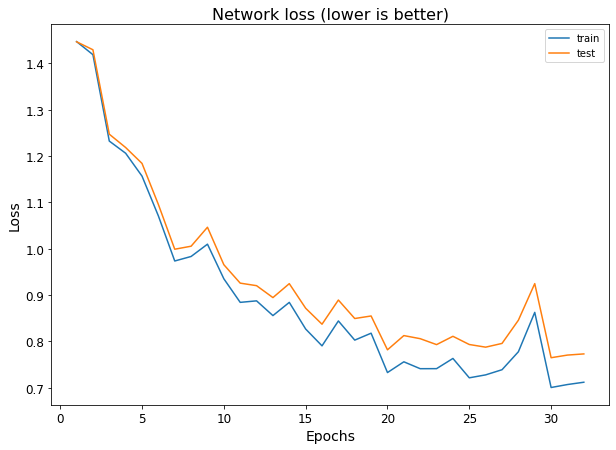

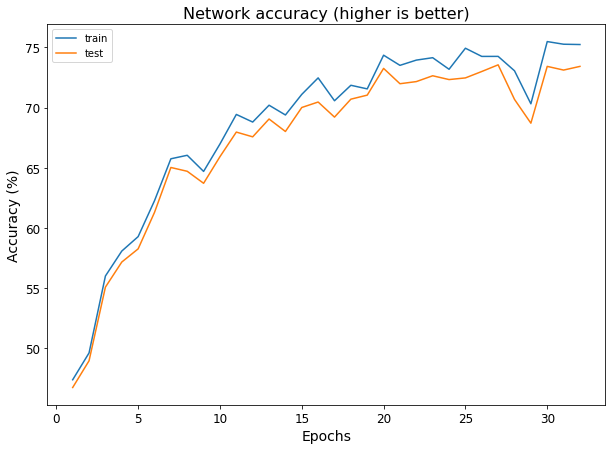

In [ ]:
epochs = np.arange(1, epoch_max + 1)
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(epochs, results["train losses"], label="train")
plt.plot(epochs, results["test losses"], label="test")
plt.title("Network loss (lower is better)", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
# plot accuracies
plt.figure(figsize=(10, 7))
plt.plot(epochs, np.asarray(results["train accuracies"]) * 100, label="train")
plt.plot(epochs, np.asarray(results["test accuracies"]) * 100, label="test")
plt.title("Network accuracy (higher is better)", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
# show plots
plt.show()

In [ ]:
@torch.no_grad()
def display_prediction(network, loader, i=0):
    inputs, labels = next(iter(loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    network.eval()
    outputs = network(inputs)
    predictions = outputs.argmax(dim=-1)
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.imshow(inputs[i].moveaxis(-3, -1).cpu())
    print(f"Predicted label: {classes[predictions[i].cpu().numpy()]} "
          f"({predictions[i].cpu().numpy()})")
    print(f"Actual label: {classes[labels[i].cpu().numpy()]} ({labels[i].cpu().numpy()})")

Predicted label: plane (0)
Actual label: plane (0)


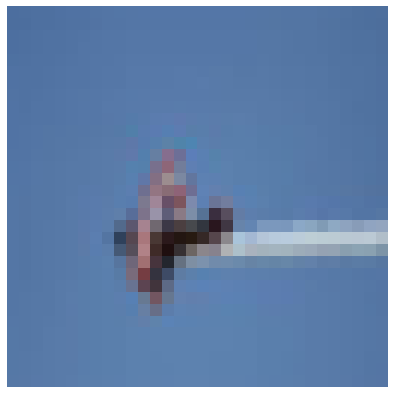

In [ ]:
display_prediction(network, train_loader)

## Saving Weights

We can save our weights as a file to be loaded later if we have our network definition set to the same thing. This can be very practical if you pre-train a model and want to deploy it in your projects, e.g., on the web.

In [ ]:
# you can put whatever extension you want, .pth (or .pt) is just the PyTorch convention
torch.save(network.state_dict(), "cifar10_model.pth")

## Loading Weights & Evaluate

In [ ]:
network_load = CNN()  # initialize a *new*, untrained network object
network_load.load_state_dict(torch.load("cifar10_model.pth"))  # load our trained weights
network_load.to(device)  # put network on GPU (if it is available)
network_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [ ]:
# evaluate our network to make sure we have loaded the weights properly :)
test_loss, test_accuracy = evaluate(test_loader, network_load, criterion)
print(f"Test accuracy: {str(test_accuracy * 100):.6}%   Test loss: {str(test_loss):.6}")

Test accuracy: 73.150%   Test loss: 0.7761


## Deploying PyTorch Models

Deploying a PyTorch model into your web app is usually not the easiest thing. For example, you would want a dedicated DevOps person in your Hackathon group where all their job is is figuring out how to do this :P

PyTorch themselves have a dencent tutorial on this: https://pytorch.org/tutorials/intermediate/flask_rest_api_tutorial.html

TLDR, you will need to save your weights and write a python script (i.e., `.py`) file that

1. takes some sort of input as a command-line argument, e.g., the path to the image, and/or takes some sort of webrequest call, and
2. with the saved weights, pass the input through your model to obtain and output, and return it somehow, e.g., via `stdout` or another webrequest.

In other words, in your `.py` file you will need your class definition of `CNN` and use the code above to load your weights.

You will probably want to use a `Flask` backend to do this as `Flask` is written in Python so everything works together well. However, it's fine if your backend is something else as long as you have some way to

1. invoke the `.py` model script (e.g., on VM-based servers via command-line arguments) and
2. receive the model output.

However, using webrequests is usually the preferred route, as the flexibility of which scripts can call and recieve outputs from other scripts is a lot better.